In [76]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import sys

sys.path.insert(0, "/workspace/believe-based-argumentation-generation/src-py/")

In [78]:
%autoreload

from evaluation import *
from text_to_beliefs import *
import utils
import numpy as np

import pandas as pd

from rouge import Rouge 
from matplotlib import pyplot as plt
from tabulate import tabulate

from scipy import stats


pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_row', 0)

In [79]:
from distinct_n import  distinct_n_corpus_level

------------------------------------

### Evaluate predictions:

In [80]:
models_path = '/workspace/ceph_data/belief-based-argumentation-generation/models'


#for evaluation model
liwc_dict_path = '/workspace/ceph_data/belief-based-argumentation-generation/data/LIWC2015_English_Flat.dic.txt'
tfidf_model_path = '/workspace/ceph_data/belief-based-argumentation-generation/models/cons_vs_lib_tfidf.pkl'
belief_model_path = '/workspace/ceph_data/belief-based-argumentation-generation/models/cons_vs_lib_classifier.pkl'

In [81]:
general_sents = [
    'In this debate , I will be arguing that',
    'The first round is for acceptance',
    'last round are for',
    'I will be arguing that',
    'The goal of this debate',
    'Round 1 : Acceptance Round 2 : Opening Argument Round 3 : Rebuttals Round 4',
    'The first round is for acceptance only',
    
]

In [130]:
def eval_table(gt_answers, approaches_preds, approachs_names, printit=True):
    approaches_bleus1 = []
    approaches_bleus2 = []
    approaches_bleus3 = []
    approaches_meteors = []
    approaches_rouge_1 = []
    approaches_rouge_2 = []
    approaches_rouge_3 = []
    approaches_rouge_l = []
    approaches_rouge_w = []
    
    #rouge = Rouge(metrics = ['rouge-n', 'rouge-l', 'rouge-w'], max_n=4, apply_avg=True)
    
    for app_preds in approaches_preds:
        approaches_bleus1.append(round(eval_bleu(gt_answers, app_preds, weights=(1, 0, 0, 0)),3))
        approaches_bleus2.append(round(eval_bleu(gt_answers, app_preds, weights=(0, 1, 0, 0)),3))
        approaches_bleus3.append(round(eval_bleu(gt_answers, app_preds, weights=(0, 0, 1, 0)),3))
        approaches_meteors.append(round(eval_meteor(gt_answers, app_preds), 3))

        #r_scores = rouge.get_scores(app_preds, gt_answers)
        #approaches_rouge_1.append(round(r_scores['rouge-1']['f'],3))
        #approaches_rouge_2.append(round(r_scores['rouge-2']['f'],3))
        #approaches_rouge_3.append(round(r_scores['rouge-3']['f'],3))
        #approaches_rouge_l.append(round(r_scores['rouge-l']['f'],3))
        #approaches_rouge_w.append(round(r_scores['rouge-w']['f'],3))

    
    table_data = [
        [name, approaches_bleus1[i], approaches_bleus2[i], approaches_bleus3[i], approaches_meteors[i]]
            for i, name in enumerate(approachs_names)
    ]
    
    if printit:
        print(tabulate(table_data, headers=['#', 'BLEU', 'BLEU-2', 'BLEU-3', 'METEOR']))
    
    return table_data

def eval_beliefs_v2(df, tgt_clm, clms, approaches_names, majority_class, printit=True):
    
    f1_scores  = []
    acc_scores = []
    
    for clm in clms:
        
        df = df_text_to_belief(df, liwc_dict_path, tfidf_model_path, belief_model_path, 
                               clm+'_belief_preds', txt_clm=clm)
        
        f1_scores.append(round(f1_score(df[tgt_clm].tolist(), df[clm+'_belief_preds'].tolist(), average='macro'), 3))
        acc_scores.append(round(accuracy_score(df[tgt_clm].tolist(), df[clm+'_belief_preds'].tolist()), 3))

    #Attach majority score
    df['majority_belief'] = [majority_class] * len(df)
    #f1_scores.append(round(f1_score(df[tgt_clm].tolist(), df['majority_belief'].tolist(), average='macro'), 3))
    #acc_scores.append(round(accuracy_score(df[tgt_clm].tolist(), df['majority_belief'].tolist()), 3))
        
    table_data = [
        [name, acc_scores[i], f1_scores[i]]
            for i, name in enumerate(approaches_names)
    ]
    
    if printit:
        print(tabulate(table_data, headers=['#', 'ACC', 'F1-SCORE']))
    
    return table_data, df


def eval_beliefs(df, clms, approachs_names,  printit=True):
    gt_beliefs = df.user_belief.tolist()

    f1_scores  = []
    acc_scores = []
    
    for clm in clms:
        clm_vals = df[clm].tolist()
        acc, f1, _ = user_ideology_from_text(clm_vals, gt_beliefs, 
                                             models_path + '/text_to_idology_model_left_right_no_other.pkl')
        f1_scores.append(round(f1, 3))
        acc_scores.append(round(acc, 3))


    table_data = [
        [name, acc_scores[i], f1_scores[i]]
            for i, name in enumerate(approachs_names)
    ]
    
    if printit:
        print(tabulate(table_data, headers=['#', 'ACC', 'F1-SCORE']))
    
    return table_data

def eval_morals(df, gt_clm, clms, approachs_names,  printit=True):

    apps_errors = []
    
    gt_texts = df[gt_clm].tolist()
    
    for clm in clms:
        gen_texts = df[clm].tolist()
        app_error = eval_moral_similarity(gt_texts, gen_texts)
        apps_errors. append(app_error)

    table_data = [
        [name, apps_errors[i]]
            for i, name in enumerate(approachs_names)
    ]
    
    if printit:
        print(tabulate(table_data, headers=['#', 'ERROR']))
    
    return table_data


def eval_distinct(approaches_preds, approaches_names,  printit=True):
    distinct_1s = []
    distinct_2s = []
    for approach_preds in approaches_preds:
        approaches_preds = [x.split(' ') for x in approach_preds]
        #approaches_preds = [[item for sublist in approaches_preds for item in sublist]]
        distinct_1 = round(distinct_n_corpus_level(approaches_preds, 1), 3)
        distinct_2 = round(distinct_n_corpus_level(approaches_preds, 2), 3)
        distinct_1s.append(distinct_1)
        distinct_2s.append(distinct_2)
        
    
    table_data = [
    [name, distinct_1s[i], distinct_2s[i]]
        for i, name in enumerate(approaches_names)
    ]
    
    if printit:
        print(tabulate(table_data, headers=['#', 'DISTINCT-1', 'DISTINCT-2']))
    
    return table_data

In [83]:
#Get user's big-issues vectors
users_info = pd.read_pickle('/workspace/ceph_data/belief-based-argumentation-generation/experiments/experiment_8/preprocessed_data/users.pkl')
users_bi   = pd.Series(users_info.big_issues.values,index=users_info.user).to_dict()

In [84]:
data  = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/experiment_8/preprocessed_data/test_df.csv')
pplm_preds = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/pplm_experiment/output/modified_topic_long_test_preds.csv')
pplm_preds_top_10_manual = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/pplm_experiment/output/pplm_manual_bi_preds.csv')
pplm_preds_top_10_auto  = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/pplm_experiment/output/pplm_auto_top_10_bi_preds.csv')
seq2seq_preds_35 = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/experiment_8/output/persona_based_test_preds.csv')
#bart_preds = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation//experiments/bart_experiment/output/test_preds_df.csv')

In [85]:
pplm_preds = pplm_preds.drop_duplicates(['user', 'topic'])
seq2seq_preds_35 = seq2seq_preds_35.drop_duplicates(['user', 'topic'])
pplm_preds_top_10_manual = pplm_preds_top_10_manual.drop_duplicates(['user', 'topic'])
pplm_preds_top_10_auto = pplm_preds_top_10_auto.drop_duplicates(['user', 'topic'])

In [86]:
#data_topics = [x[0] for x in seq2seq_preds_35.topic.value_counts().to_dict().items() if x[1] > 1]
#filter out rows rows on topics with one answer
#pplm_preds = pplm_preds[pplm_preds.topic.isin(data_topics)]
#seq2seq_preds_35 = seq2seq_preds_35[seq2seq_preds_35.topic.isin(data_topics)]

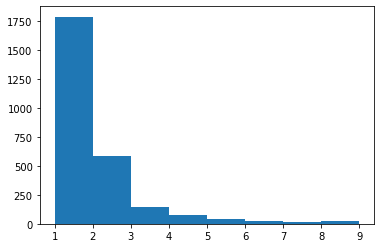

In [87]:
plt.hist(seq2seq_preds_35.topic.value_counts().to_dict().values(), bins=range(1, 10, 1))
plt.show()

In [88]:
#bow_based_preds = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/pplm_experiment/output/pplm_preds_bi_new_bows_25_0.2_2.0.csv')
#pplm_preds['user_bi_bow_based_pred_claim'] = bow_based_preds['user_bi_bow_based_pred_claim'].tolist()

In [89]:
# pplm_preds_10 = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/pplm_experiment/output/pplm_preds_user_bow_top_10.csv')
# pplm_preds_50 = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/pplm_experiment/output/pplm_preds_user_bow_top_50.csv')
# pplm_preds_100 = pd.read_csv('/workspace/ceph_data/belief-based-argumentation-generation/experiments/pplm_experiment/output/pplm_preds_user_bow_top_100.csv')
# pplm_preds['user_bow_based_pred_claim_10'] = pplm_preds_10['user_bow_based_pred_claim'].tolist()
# pplm_preds['user_bow_based_pred_claim_50'] = pplm_preds_50['user_bow_based_pred_claim'].tolist()
# pplm_preds['user_bow_based_pred_claim_100'] = pplm_preds_100['user_bow_based_pred_claim'].tolist()

In [90]:
data['vis_bi'] = data.user.apply(lambda x: utils.desc_user_from_vec(users_bi[x]))
data['vis_bi_len'] = data.vis_bi.apply(lambda x: len(x))
# data = data[data.vis_bi_len < 5]

In [91]:
pplm_preds['vis_bi'] = pplm_preds.user.apply(lambda x: utils.desc_user_from_vec(users_bi[x]))
pplm_preds['vis_bi_len'] = pplm_preds.vis_bi.apply(lambda x: len(x))
pplm_preds['topic_len'] = pplm_preds.topic.apply(lambda x: len(x.split()))
#pplm_preds = pplm_preds[pplm_preds.topic_len < 5]

In [92]:
pplm_preds_top_10_auto['vis_bi'] = pplm_preds_top_10_auto.user.apply(lambda x: utils.desc_user_from_vec(users_bi[x]))
pplm_preds_top_10_auto['vis_bi_len'] = pplm_preds_top_10_auto.vis_bi.apply(lambda x: len(x))
pplm_preds_top_10_auto['topic_len'] = pplm_preds_top_10_auto.topic.apply(lambda x: len(x.split()))

In [93]:
pplm_preds_top_10_manual['vis_bi'] = pplm_preds_top_10_manual.user.apply(lambda x: utils.desc_user_from_vec(users_bi[x]))
pplm_preds_top_10_manual['vis_bi_len'] = pplm_preds_top_10_manual.vis_bi.apply(lambda x: len(x))
pplm_preds_top_10_manual['topic_len'] = pplm_preds_top_10_manual.topic.apply(lambda x: len(x.split()))

In [94]:
seq2seq_preds_35['vis_bi'] = seq2seq_preds_35.user.apply(lambda x: utils.desc_user_from_vec(users_bi[x]))
seq2seq_preds_35['vis_bi_len'] = seq2seq_preds_35.vis_bi.apply(lambda x: len(x))
seq2seq_preds_35['topic_len'] = seq2seq_preds_35.topic.apply(lambda x: len(x.split()))
#seq2seq_preds_35 = seq2seq_preds_35[seq2seq_preds_35.topic_len < 5]
#seq2seq_preds_35 = seq2seq_preds_35[seq2seq_preds_35.vis_bi_len < 15]

In [95]:
def text_contain_general_statements(text):
    for x in general_sents:
        if x.lower() in text.lower():
            return True
            break
    return False

In [96]:
print('pplm:', len([x for x in pplm_preds.user_bi_bow_based_pred_claim.tolist() 
     if text_contain_general_statements(x)]))
print('seq2seq:', len([x for x in seq2seq_preds_35.big_issues_preds.tolist() 
     if text_contain_general_statements(x)]))
print('gt:', len([x for x in seq2seq_preds_35.top_claim.tolist() 
     if text_contain_general_statements(str(x))]))

pplm: 200
seq2seq: 1194
gt: 41


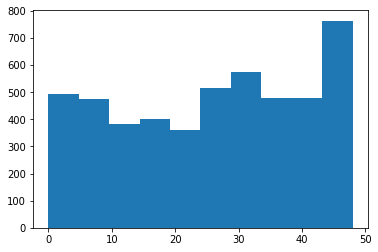

In [97]:
plt.hist(pplm_preds.vis_bi_len.tolist())
plt.show()

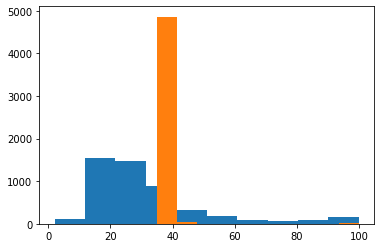

In [98]:
plt.hist([len(x.split(' ')) for x in pplm_preds.user_bi_bow_based_pred_claim.tolist()])
plt.hist([len(x.split(' ')) for x in seq2seq_preds_35.big_issues_preds.tolist()])
plt.show()

In [99]:
pplm_preds[['topic', 'vis_bi', 'user_bi_bow_based_pred_claim']].head(n=25)

,topic,vis_bi,user_bi_bow_based_pred_claim
0,should animals be treated equally to humans?,"{'Abortion': 1, 'Affirmative Action': 1, 'Animal Rights': 1, 'Environmental Protection': 3, 'Gay Marriage': 1, 'Global Warming Exists': 3, 'Gun Rights': 3, 'Homeschooling': 3, 'Internet Censorship': 1, 'Iran-Iraq War': 1, 'Legalized Prostitution': 3, 'Medicaid & Medicare': 3, 'Minimum Wage': 3, 'Occupy Movement': 1, 'Smoking Ban': 3, 'Social Programs': 3, 'Social Security': 3}",<|endoftext|>animals are better than humans because they have a higher IQ and can think for themselves.
1,cheese itz are better than ritz,"{'Abortion': 3, 'Affirmative Action': 3, 'Animal Rights': 1, 'Barack Obama': 3, 'Border Fence': 3, 'Capitalism': 3, 'Civil Unions': 1, 'Death Penalty': 3, 'Drug Legalization': 1, 'Electoral College': 3, 'Environmental Protection': 1, 'Estate Tax': 1, 'European Union': 1, 'Euthanasia': 3, 'Federal Reserve': 1, 'Flat Tax': 3, 'Free Trade': 1, 'Gay Marriage': 1, 'Global Warming Exists': 1, 'Globalization': 1, 'Gold Standard': 3, 'Gun Rights': 3, 'Homeschooling': 1, 'Internet Censorship': 3, 'Iran-Iraq War': 3, 'Labor Union': 1, 'Legalized Prostitution': 3, 'Medicaid & Medicare': 1, 'Medical Marijuana': 3, 'Military Intervention': 3, 'Minimum Wage': 1, 'National Health Care': 1, 'National Retail Sales Tax': 1, 'Occupy Movement': 1, 'Progressive Tax': 1, 'Racial Profiling': 3, 'Redistribution': 3, 'Smoking Ban': 1, 'Social Programs': 1, 'Social Security': 1, 'Socialism': 1, 'Stimulus Spending': 1, 'Term Limits': 1, 'Torture': 3, 'United Nations': 1, 'War in Afghanistan': 3, 'War on Terror': 1, 'Welfare': 1}","<|endoftext|>ritz are not a good idea. They will only create more problems than they solve, and the money spent on them is going to be wasted anyway."
2,can genetically modified foods solve world hunger?,"{'Abortion': 1, 'Animal Rights': 3, 'Border Fence': 1, 'Civil Unions': 3, 'Death Penalty': 1, 'Drug Legalization': 1, 'Euthanasia': 1, 'Gay Marriage': 1, 'Minimum Wage': 3, 'Redistribution': 1, 'Smoking Ban': 3}",<|endoftext|>can genetically modified foods help fight obesity rates. http://www2.org... The main reason is that it will help people lose weight and increase their health.
3,has multiculturalism failed in europe?,"{'Abortion': 1, 'Animal Rights': 3, 'Border Fence': 1, 'Civil Unions': 3, 'Death Penalty': 1, 'Drug Legalization': 1, 'Euthanasia': 1, 'Gay Marriage': 1, 'Minimum Wage': 3, 'Redistribution': 1, 'Smoking Ban': 3}",<|endoftext|>multiculturalism is a bad idea. 1) It will cause more problems than it solves.
...,...,...,...
21,dose chicken make you fat?,"{'Affirmative Action': 3, 'Animal Rights': 3, 'Barack Obama': 3, 'Border Fence': 1, 'Death Penalty': 1, 'Drug Legalization': 1, 'Electoral College': 3, 'Estate Tax': 1, 'Flat Tax': 1, 'Free Trade': 3, 'Gay Marriage': 3, 'Gun Rights': 1, 'Minimum Wage': 1, 'National Health Care': 3, 'National Retail Sales Tax': 1, 'Progressive Tax': 1, 'Smoking Ban': 3, 'Social Programs': 3, 'Social Security': 3, 'Socialism': 3, 'Torture': 1, 'United Nations': 3}",<|endoftext|>dose chicken n chips are better than waffles. They have more flavor and they taste good.
22,is comedy an actual art form?,"{'Affirmative Action': 3, 'Animal Rights': 3, 'Barack Obama': 3, 'Border Fence': 1, 'Death Penalty': 1, 'Drug Legalization': 1, 'Electoral College': 3, 'Estate Tax': 1, 'Flat Tax': 1, 'Free Trade': 3, 'Gay Marriage': 3, 'Gun Rights': 1, 'Minimum Wage': 1, 'National Health Care': 3, 'National Retail Sales Tax': 1, 'Progressive Tax': 1, 'Smoking Ban': 3, 'Social Programs': 3, 'Social Security': 3, 'Socialism': 3, 'Torture': 1, 'United Nations': 3}",<|endoftext|>an actual art form is the best. It has a lot of variety and it's not just one type of painting.
23,should cloning be allowed,"{'Affirmative Action': 3, 'Animal Rights': 3, 'Barack Obama': 3, 'Border Fence': 1, 'Death Penalty': 1, 'Drug Legalization': 1, 'Electoral College': 3, 'Estate Tax': 1, 'Flat Tax': 1, 'Free Trade': 3, 'Gay Ma

### pplm eval:

In [131]:
gt_answers = [str(x) for x in pplm_preds.top_claim.tolist()]
topics = pplm_preds.topic.tolist()
uncond_preds   = [x[1].replace('<|endoftext|>', '') for x in enumerate(pplm_preds.uncond_pred_claim.tolist())]
bi_bow_preds   = [x[1].replace('<|endoftext|>', '') for x in enumerate(pplm_preds.user_bi_bow_based_pred_claim.tolist())]

results = eval_table(gt_answers, [uncond_preds, bi_bow_preds], ['uncoditioned', 'bi_bow'])

#               BLEU    BLEU-2    BLEU-3    METEOR
------------  ------  --------  --------  --------
uncoditioned   9.614     1.258     0.258     0.083
bi_bow        11.939     0.951     0.159     0.107


In [101]:
results = eval_distinct([uncond_preds, bi_bow_preds], ['uncoditioned', 'bi_bow'])

#               DISTINCT-1    DISTINCT-2
------------  ------------  ------------
uncoditioned         0.736         0.791
bi_bow               0.948         0.936


### seq2seq eval:

In [102]:
seq2seq_preds_35[['topic', 'top_claim', 'baseline_preds', 'big_issues_preds']].head(n=25)

,topic,top_claim,baseline_preds,big_issues_preds
0,should animals be treated equally to humans?,"If you think all animals are nice kind furry animals , you must have missed those articles about sea otters .","<claim> If a person wants to take care of others , then they should have the right to do what they want , and if they do n't like it , they are the ones who are . </claim>","<claim> I believe that animals should be treated equally , and that we should not be able to do what they are doing . ' </claim> ) '' Animals do not belong to animals . </claim>"
1,cheese itz are better than ritz,"I shall give you warning now that the right honorable Jacob Rees-Mogg , particularly in aid of and by Sixtus Dominic Boniface Christopher Rees-Mogg shall not tolerate these intolerable hate crimes against Ritz .","<claim> The point of this debate is to discuss whether or not it is better to be considered a `` better '' than an actual type of candy , but that is not true . </claim>","<claim> The only thing that can be made is that you have to have participated in AT LEAST ONE debate , and I would like to thank my opponent for creating this debate . </claim>"
2,can genetically modified foods solve world hunger?,It is moral wrong In my opinion it is wrong to use gmos because it may cause the new plants to out compete other plants and posing make them extinct .,"<claim> The `` Natural Selection '' is a “ organic ” that has been proven to be genetically modified , and that it is not possible that humans are genetically identical to humans . </claim>","<claim> If we are genetically genetically advanced , we would be able to do what we want , and we should not allow it to be modified as it is not as harmful . </claim>"
3,has multiculturalism failed in europe?,Yes it has Multiculturalism has failed in Europe because there are conflicts between different races and religions .,"<claim> I will be arguing that the United States of America should not be allowed in order to uphold the status quo , and that it is a violation of freedom of speech . </claim>","<claim> The idea that the government has a right to do what is right and wrong is that it is not a good thing to happen , but that does n't mean it 's bad . </claim>"
...,...,...,...,...
21,dose chicken make you fat?,"It helps to build muscle , aids your cell structure to become stronger , they make your body be able to move , it helps you to do exercise for a longer period without getting tired or the need to have a break .","<claim> The intent of this debate is to determine whether or not the chicken meets the egg , or whether it should be done in the first place , as well as possible . </claim>","<claim> I will be arguing for the statement that milk is not a good thing , and my opponent will argue that it is a waste of time and the chicken is an egg . </claim>"
22,is comedy an actual art form?,No one should say no to this topic because comedy is also a type of genre you have on tele .,"<claim> If the first round is for acceptance , then you can not use any of these videos in the last round , but no new arguments can be made in round 2 . </claim>","<claim> If a movie is a piece of art , then it is not an art . ' '' it does n't matter if you do n't like it or not , it 's not art . </claim>"
23,should cloning be allowed,I believe it will benefit our society and bring women into the picture of hopefully being known for their kindness and brains rather than other things ... .,"<claim> If you think that cloning should be banned , I would like to point out that this is not a debate on whether or not cloning is a good thing to do . </claim>","<claim> If you think that cloning should be banned , I will be arguing that it should not be legalized , and my opponent will argue why it is a waste of time . </claim>"
24,should the u.s. deport justin bieber?,I think people hate him so much because he is so cocky which is n't reason enough to have him deported .,"<claim> The United States should have the right to dec

In [132]:
gt_answers = [str(x) for x in seq2seq_preds_35.top_claim.tolist()]
baseline_preds   = [x.replace('<claim>', '').replace('</claim>', '') for x in seq2seq_preds_35.baseline_preds.tolist()]
bi_preds         = [x.replace('<claim>', '').replace('</claim>', '') for x in seq2seq_preds_35.big_issues_preds.tolist()]

print('seq2seq 35:')
results = eval_table(gt_answers, [baseline_preds, bi_preds], ['baseline', 'big_issues'])

seq2seq 35:
#             BLEU    BLEU-2    BLEU-3    METEOR
----------  ------  --------  --------  --------
baseline    18.248     2.206     0.437     0.158
big_issues  18.388     2.256     0.456     0.158


In [104]:
results = eval_distinct([baseline_preds, bi_preds], ['baseline', 'big_issues'])

#             DISTINCT-1    DISTINCT-2
----------  ------------  ------------
baseline           0.763         0.97
big_issues         0.756         0.969


### Significance Test:

In [133]:
def check_sig(v1s, v2s, alpha=0.05):
    from scipy import stats

    diff = list(map(lambda x1 , x2: x1 - x2, v1s, v2s))
    is_normal = stats.shapiro(diff)[1] > alpha
    
    ttest = stats.ttest_rel(v1s, v2s) if is_normal else stats.wilcoxon(v1s, v2s)
    if ttest.statistic >=0:
        if (ttest.pvalue/2) <= alpha:
            return True
        else:
            return False
    else:
        return False

In [134]:
list_of_indxs = np.array_split(pplm_preds.index, 10)
list_of_pplm_dfs = [pplm_preds.loc[idx] for idx in list_of_indxs]
list_of_seq2seq_dfs = [seq2seq_preds_35.loc[idx] for idx in list_of_indxs]

#### BLEU & METEOR:

In [135]:
list_of_pplm_table_scores = []
for df in list_of_pplm_dfs:
    gt_answers = [str(x) for x in df.top_claim.tolist()]
    topics = df.topic.tolist()
    uncond_preds   = [x.replace('<|endoftext|>', '') for x in df.uncond_pred_claim.tolist()]
    bi_bow_preds   = [x.replace('<|endoftext|>', '') for x in df.user_bi_bow_based_pred_claim.tolist()]
    results_table  = eval_table(gt_answers, [uncond_preds, bi_bow_preds], ['uncoditioned','bi_bow'], printit=False)
    list_of_pplm_table_scores.append(results_table)

In [136]:
list_of_seq2seq_table_scores = []
for df in list_of_seq2seq_dfs:
    gt_answers = [str(x) for x in df.top_claim.tolist()]
    baseline_preds   = df.baseline_preds.tolist()
    bi_preds         = df.big_issues_preds.tolist()
    results_table    = eval_table(gt_answers, [baseline_preds, bi_preds], ['baseline', 'big_issues'], printit=False)
    list_of_seq2seq_table_scores.append(results_table)

In [137]:
for i, measure in enumerate(['bleu-1', 'bleu-2', 'bleu-3', 'meteor']):
    m_scores1 = [x[0][i+1] for x in list_of_pplm_table_scores]
    m_scores2 = [x[1][i+1] for x in list_of_pplm_table_scores]
    print('{}: pvalue for bi_bow vs unconditioned is {}'.format(measure, 
                                                                check_sig(m_scores2, m_scores1, alpha=0.05)))

bleu-1: pvalue for bi_bow vs unconditioned is True
bleu-2: pvalue for bi_bow vs unconditioned is False
bleu-3: pvalue for bi_bow vs unconditioned is False
meteor: pvalue for bi_bow vs unconditioned is True


In [138]:
for i, measure in enumerate(['bleu-1', 'bleu-2', 'meteor']):
    m_scores1 = [x[0][i+1] for x in list_of_seq2seq_table_scores]
    m_scores2 = [x[1][i+1] for x in list_of_seq2seq_table_scores]
    print('{}: pvalue for big_issues vs unconditioned is {}'.format(measure, 
                                                                check_sig(m_scores2, m_scores1, alpha=0.05)))

bleu-1: pvalue for big_issues vs unconditioned is True
bleu-2: pvalue for big_issues vs unconditioned is True
meteor: pvalue for big_issues vs unconditioned is False


In [139]:
for i, measure in enumerate(['bleu-1', 'bleu-2', 'meteor']):
    m_scores1 = [x[1][i+1] for x in list_of_pplm_table_scores]
    m_scores2 = [x[1][i+1] for x in list_of_seq2seq_table_scores]
    print('{}: pvalue for pplm vs seq2seq is {}'.format(measure, 
                                                        check_sig(m_scores1, m_scores2, alpha=0.05)))

bleu-1: pvalue for pplm vs seq2seq is False
bleu-2: pvalue for pplm vs seq2seq is False
meteor: pvalue for pplm vs seq2seq is False


#### Distinct-1 and 2:

In [126]:
list_of_pplm_table_scores = []
for df in list_of_pplm_dfs:
    gt_answers = [str(x) for x in df.top_claim.tolist()]
    topics = df.topic.tolist()
    uncond_preds   = [x.replace('<|endoftext|>', '') for x in df.uncond_pred_claim.tolist()]
    bi_bow_preds   = [x.replace('<|endoftext|>', '') for x in df.user_bi_bow_based_pred_claim.tolist()]
    results_table  = eval_distinct([uncond_preds, bi_bow_preds], ['uncoditioned','bi_bow'], printit=False)
    list_of_pplm_table_scores.append(results_table)

In [127]:
list_of_seq2seq_table_scores = []
for df in list_of_seq2seq_dfs:
    gt_answers = [str(x) for x in df.top_claim.tolist()]
    baseline_preds   = df.baseline_preds.tolist()
    bi_preds         = df.big_issues_preds.tolist()
    results_table    = eval_distinct([baseline_preds, bi_preds], ['baseline', 'big_issues'], printit=False)
    list_of_seq2seq_table_scores.append(results_table)

In [128]:
for i, measure in enumerate(['distinct-1', 'distinct-2']):
    m_scores1 = [x[0][i+1] for x in list_of_pplm_table_scores]
    m_scores2 = [x[1][i+1] for x in list_of_pplm_table_scores]
    print('{}: pvalue for pplm cond vs uncond is {}'.format(measure, 
                                                        check_sig(m_scores2, m_scores1, alpha=0.05)))

distinct-1: pvalue for pplm cond vs uncond is True
distinct-2: pvalue for pplm cond vs uncond is True


In [129]:
for i, measure in enumerate(['distinct-1', 'distinct-2']):
    m_scores1 = [x[0][i+1] for x in list_of_seq2seq_table_scores]
    m_scores2 = [x[1][i+1] for x in list_of_seq2seq_table_scores]
    print('{}: pvalue for seq2seq cond vs uncond is {}'.format(measure, 
                                                        check_sig(m_scores2, m_scores1, alpha=0.05)))

distinct-1: pvalue for seq2seq cond vs uncond is False
distinct-2: pvalue for seq2seq cond vs uncond is True


/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Create sample for manual evaluation:

In [53]:
topic_bi_pairs = pickle.load(open('/workspace/ceph_data/belief-based-argumentation-generation/data/test_big_issues_topic_10_each_lvl.pkl', 'rb'))
top_10_bi = ['Abortion', 'Death Penalty', 'Gay Marriage', 'Drug Legalization', 'Global Warming Exists', 'Environmental Protection', 'Medical Marijuana', 'Smoking Ban', 'Minimum Wage', 'Border Fence']

def merge_two_clms(c1, c2):
    l1 = c1.split('\n')
    l2 = c2.split('\n')
    output= []
    for x in zip(l1, l2):
        output.append(x[0] + ' \n ' + x[1] + ' \n ')
    return ' \n '.join(output)

def filter_out_big_issues(row, rel_lvls=[]):
    output_row = {}
    for bi in row['vis_bi'].items():
        if (row['topic'], bi[0]) in topic_bi_pairs and topic_bi_pairs[(row['topic'], bi[0])] in rel_lvls and row['topic'] != 'god exists':
            output_row[bi[0]] = bi[1]
    return output_row

def user_has_stance_on_bi(bi, bi_vec):
    return bi in bi_vec

In [56]:
pplm_preds_top_10_auto['seq2seq_big_issues']  = seq2seq_preds_35['big_issues_preds'].tolist()
pplm_preds_top_10_auto['user_bi_bow_based_pred_claim_manual']  = pplm_preds_top_10_manual['user_bi_bow_based_pred_claim'].tolist()
pplm_preds_top_10_auto['filtered_vis_bi']     = pplm_preds_top_10_auto.apply(lambda row: filter_out_big_issues(row, rel_lvls=[2]), axis=1)
pplm_preds_top_10_auto['filtered_vis_bi_no_answer'] = pplm_preds_top_10_auto.filtered_vis_bi.apply(lambda x: {y[0]: '?' for y in x.items()})
pplm_preds_top_10_auto['filtered_vis_bi_len'] = pplm_preds_top_10_auto.filtered_vis_bi.apply(lambda x: len(x.items()))
pplm_preds_top_10_auto['top_10_bi_vis'] = pplm_preds_top_10_auto.vis_bi.apply(lambda x: {y[0]: y[1] for y in x.items()  if y[0] in top_10_bi})

In [58]:
pplm_preds_top_10_auto[pplm_preds_top_10_auto.user_bi_bow_based_pred_claim=='<|endoftext|>should murder be legalized? I think that abortion should not be legal. Abortion is killing a baby, and it\'s wrong to kill an innocent human being.'][['top_10_bi_vis', 'user_bi_bow', 'topic', 'user_bi_bow_based_pred_claim', 'user_bi_bow_based_pred_claim_manual']].head()

,top_10_bi_vis,user_bi_bow,topic,user_bi_bow_based_pred_claim,user_bi_bow_based_pred_claim_manual
1114,"{'Abortion': 3, 'Border Fence': 1, 'Death Penalty': 1, 'Drug Legalization': 3, 'Environmental Protection': 3, 'Gay Marriage': 3, 'Global Warming Exists': 3, 'Medical Marijuana': 3, 'Minimum Wage': 3, 'Smoking Ban': 3}","['health', 'country', 'legalized', 'heat', 'patients', 'wrongly', 'legalizing', 'equal', 'surface', 'pollution', 'smoker', 'adopt', 'result', 'amount', 'varrack', 'young', 'convicted', 'people', 'killing', 'couple', 'prisoners', 'aborted', 'personhood', 'embyro', 'penn', 'rights', 'glaucoma', 'monopsonistic', 'subpoint', 'religious', 'resource', 'dioxide', 'procon', 'lung', 'protecting', 'someone', 'protection', 'healthy', 'nonborder', 'substance', 'resources', 'contraceptive', 'medical', 'teller', 'businesses', 'prescription', 'monopsony', 'graph', 'places', 'others', 'retribution', 'marry', 'stop', 'levels', 'children', 'minimum', 'drugs', 'less', 'prices', 'market', 'bans', 'alzheimer', 'production', 'illicit', 'punishments', 'increased', 'perry', 'pain', 'erosion', 'prioritize', 'methane', 'degradation', 'inequality', 'carbon', 'increasing', 'would', 'increase', 'hour', 'lungs', 'wage', 'treatment', 'prioritization', 'tharnish', 'churches', 'nasa', 'right', 'choice', 'cells', 'fiscal', 'build', 'murdered', 'goes', 'harm', 'wealth', 'infrared', 'jail', 'radiation', 'smoking', 'hiring', 'addictive', 'water', 'heart', 'actually', 'skeptics', 'countries', 'plea', 'report', 'greenhouse', 'deforestation', 'data', 'work', 'developing', 'allowing', 'ineffective', 'chemotherapy', 'bears', 'circumstances', 'tinyurl', 'median', 'decriminalization', 'conflict', 'studies', 'addiction', 'psychedelics', 'homosexual', 'lwop', 'drug', 'dollars', 'regulation', 'incapacitation', 'evidence', 'penalties', 'dangerous', 'parents', 'alive', 'recognizing', 'procedures', 'legalization', 'homemade', 'doctors', 'harmful', 'forest', 'help', 'atmosphere', 'foot', 'cancer', 'endangered', 'prescribed', 'mother', 'justified', 'procedure', 'revenge', 'natural', 'secondhand', 'deaths', 'thett', 'impact', 'employees', 'martha', 'economy', 'couples', 'cannabis', 'albania', 'definite', 'publication', 'welfare', 'recognized', 'square', 'organs', 'environment', 'homosexuals', 'working', 'criminalization', 'surgeon', 'migrate', 'fetus', 'exposure', 'polygamy', 'consumption', 'lives', 'bargains', 'nytimes', 'million', 'cigars', 'illegal', 'nonsmokers', 'abortion', 'harms', 'abuse', 'hippocratic', 'straight', 'effect', 'prosecutors', 'gases', 'curse', 'legal', 'alcohol', 'business', 'option', 'enforcement', 'smoke', 'murder', 'epilepsy', 'environmental', 'performed', 'exists', 'cartels', 'victim', 'green', 'earth', 'gays', 'prohibition', 'haines', 'decade', 'migrants', 'orientation', 'dudley', 'disease', 'nausea', 'counted', 'benefits', 'user', 'teenage', 'firms', 'considered', 'guilty', 'married', 'lower', 'paid', 'money', 'employee', 'temperatures', 'baby', 'extraction', 'hurts', 'capital']",should murder be legalized?,"<|endoftext|>should murder be legalized? I think that abortion should not be legal. Abortion is killing a baby, and it's wrong to kill an innocent human being.","<|endoftext|>should murder be legalized? I think that it should not. It is a very dangerous drug and people who use marijuana are more likely to get into accidents than those using alcohol or cigarettes, which can lead them in the wrong direction."
1447,"{'Abortion': 3, 'Border Fence': 1, 'Death Penalty': 1, 'Environmental Protection': 3, 'Gay Marriage': 3, 'Global Warming Exists': 3, 'Medical Marijuana': 3, 'Minimum Wage': 3, 'Smoking Ban': 1}","['country', 'legalized', 'heat', 'patients', 'wrongly', 'equal', 'surface', 'pollution', 'adopt', 'result', 'amount', 'varrack', 'young', 'convicted', 'people', 'killing', 'couple', 'government', 'prisoners', 'networks', 'aborted', 'personhood', 'embyro', 'penn', 'rights', 'glaucoma', 'monopsonistic', 'religious', 'resource', 'd

In [118]:
all_dfs=[pplm_preds[(pplm_preds.topic==x[0][0]) & (list(pplm_preds.filtered_vis_bi.apply(lambda v: x[0][1] in v)))] for x in list(topic_bi_pairs.items())]

How many pairs with no arguments?

In [119]:
num_cases_per_pair = [(x[0], len(x[1])) for x in zip(topic_bi_pairs.items(), all_dfs)]
len([x for x in num_cases_per_pair if x[1] == 0])

32

In [120]:
#filter in from each df only user's stance on the corrsponding big-issue
for pair in enumerate(topic_bi_pairs.keys()):
    all_dfs[pair[0]]['bi_stance'] = all_dfs[pair[0]]['filtered_vis_bi'].apply(lambda x: {pair[1][1]: x[pair[1][1]]})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
sample_df = pd.concat([x.sample(5) if len(x) > 5 else x for x in all_dfs])
sample_df['rel_lvl'] = sample_df.apply(lambda row: topic_bi_pairs[(row['topic'], list(row['bi_stance'].keys())[0])] , axis=1)
#sample_df[sample_df.rel_lvl==4][['topic', 'bi_stance', 'user_bi_bow', 'rel_lvl', 'uncond_pred_claim', 'user_bi_bow_based_pred_claim', 'top_claim']].head(n=30)

#balance the sample
sample_df_lvl2 = sample_df[sample_df['rel_lvl'] == 2].sample(30)
#sample_df_lvl3 = sample_df[sample_df['rel_lvl'] == 3].sample(30)
#sample_df_lvl4 = sample_df[sample_df['rel_lvl'] == 4].sample(30)
#sample_df = pd.concat([sample_df_lvl3 , sample_df_lvl4])
sample_df = sample_df_lvl2

In [129]:
lvls = []
for idx, row in sample_df.iterrows():
    for bi in row['bi_stance'].keys():
        lvls.append(topic_bi_pairs[(row['topic'], bi)])

In [130]:
len(lvls)

30

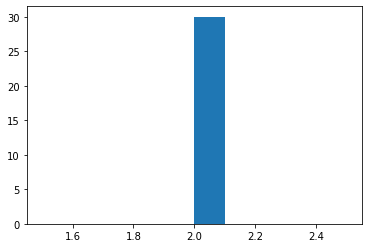

In [131]:
plt.hist(lvls)
plt.show()

In [132]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [133]:
from nltk import sent_tokenize
sample_df['gt_claim'] = sample_df.apply(lambda row: sent_tokenize(row['opinion_txt'])[0] if pd.isnull(row['top_claim']) else row['top_claim'], axis=1)
sample_df['user_bi_bow_based_pred_claim'] = sample_df['user_bi_bow_based_pred_claim'].apply(lambda x: x.replace('<|endoftext|>', '').replace('=', ''))
sample_df['user_bi_bow_based_pred_claim_manual'] = sample_df['user_bi_bow_based_pred_claim_manual'].apply(lambda x: x.replace('<|endoftext|>', '').replace('=', ''))
sample_df['uncond_pred_claim'] = sample_df['uncond_pred_claim'].apply(lambda x: x.replace('<|endoftext|>', '').replace('=', ''))


In [134]:
#pplm_uncond_df = sample_df[['bi_stance', 'topic', 'rel_lvl', 'user_bi_bow_based_pred_claim', 'uncond_pred_claim', 'corrected_top_claim']]
#pplm_uncond_df = pplm_uncond_df.drop_duplicates(subset=['topic', 'uncond_pred_claim'])

In [135]:
sample_df['gt_stance']    = sample_df.bi_stance.apply(lambda x: list(x.values())[0])
sample_df['gt_big_issue'] = sample_df.bi_stance.apply(lambda x: list(x.keys())[0])
sample_df = sample_df[['gt_big_issue', 'gt_stance', 'topic', 'rel_lvl', 'user_bi_bow_based_pred_claim', 'user_bi_bow_based_pred_claim_manual', 'uncond_pred_claim', 'gt_claim', 'seq2seq_big_issues']]
sample_df.columns = ['gt_big_issue', 'gt_stance', 'topic', 'rel_lvl', 'approach_auto', 'approach_manual', 'uncond_baseline', 'gt_claim', 'seq2seq-_pproach']

#sample_df.to_pickle('./sample_for_evaluation.pkl')
#sample_df.to_csv('./sample_for_evaluation_only_3_and_4_lvls_manual_and_auto.csv')
#sample_df.to_csv('./sample_for_evaluation_only_2_lvls_manual_and_auto.csv')
#pplm_uncond_df[['bi_stance', 'topic', 'rel_lvl', 'user_bi_bow_based_pred_claim', 'uncond_pred_claim', 'corrected_top_claim']].to_csv('./pplm_uncond_sample_for_evaluation.csv')

In [142]:
len(crowd_sourcing_df)

120

In [137]:
dfs =[sample_df[['gt_big_issue', 'gt_stance', 'topic', 'rel_lvl', 'approach_auto']],
      sample_df[['gt_big_issue', 'gt_stance', 'topic', 'rel_lvl', 'approach_manual']],
      sample_df[['gt_big_issue', 'gt_stance', 'topic', 'rel_lvl', 'uncond_baseline']],
      sample_df[['gt_big_issue', 'gt_stance', 'topic', 'rel_lvl', 'gt_claim']]
]

approaches = ['pplm-auto', 'pplm-manual', 'pplm-uncond', 'gt']
for idx, df in enumerate(dfs):
    df.columns = ['gt_big_issue', 'gt_stance', 'topic', 'rel_lvl', 'claim']
    df['approach'] = [approaches[idx]] * len(df)

crowd_sourcing_df = pd.concat(dfs)
crowd_sourcing_df.reset_index(inplace = True) 
crowd_sourcing_df.to_csv('./crowd_sourcing_lvl_2.csv')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [138]:
crowd_sourcing_df.head()

,index,gt_big_issue,gt_stance,topic,rel_lvl,claim,approach
0,381,Abortion,1,does religion impede progress?,2,"religion is a religion, and it should be illegal. I am not saying that people who are gay or lesbian shouldn't have the right to marry but they shouldnt get married at all because of their sexual orientation! It's like if you were born with an X-ray gene in your brain then when someone else has sex with them they will die.",pplm-auto
1,254,Abortion,3,does religion impede progress?,2,religion is a very good source for information. I have read many of the religious books and they are all extremely biased.,pplm-auto
2,574,Minimum Wage,1,should the government continue to fund welfare?,2,"the government is not a democracy. The people are the ones who elect them, and they have to follow their laws because of that fact alone! If you want your country back then go for it! You can't just say ""I don't like this law"" or something else.",pplm-auto
3,1535,Abortion,3,does religion impede progress?,2,"religion is a religion, and it should be illegal. I am not religious but i believe in god so why would you want to kill him? He was the one who made us humans! If he wanted people like that then we wouldn't have been here today because of his actions.",pplm-auto
4,75,Smoking Ban,3,is freedom more important than security,2,"security would be a good idea. It is not necessary to have security guards at every door, but it could help prevent people from entering the building without being able to get in or out of their cars.",pplm-auto


In [139]:
crowd_sourcing_map = crowd_sourcing_df.groupby(['gt_big_issue', 'claim']).agg({'index': list}).reset_index()
sample_df.to_pickle('./crowd_sourcing_map_of_similar_claims.pkl')

In [140]:
similar_cases = [x for x in crowd_sourcing_map['index'].tolist() if len(x) > 1]

In [141]:
crowd_sourcing_unique_df = crowd_sourcing_df.drop_duplicates(['gt_big_issue', 'claim'])
crowd_sourcing_unique_df.to_csv('./crowd_sourcing_unique_cases.csv')

In [67]:
crowd_sourcing_unique_df.head()

,index,gt_big_issue,gt_stance,topic,rel_lvl,claim,approach
0,1098,Gay Marriage,3,same-sex marriage: yes or no?,3,"same-sex marriage is not a right. It's illegal in many states, and it should be banned everywhere else.",pplm-auto
1,159,Gay Marriage,3,same-sex marriage: yes or no?,3,"same-sex marriage is not a right. It's illegal in all 50 states, and it should be banned everywhere else.",pplm-auto
2,502,Gay Marriage,3,same-sex marriage: yes or no?,3,"same-sex marriage bans are not a violation of religious freedom. The Supreme Court has ruled that the right to marry is an individual's fundamental rights, and therefore does NOT apply equally to same sex couples as heterosexuals.",pplm-auto
3,961,Abortion,1,should gender-selective abortion be legal?,3,"gender-selective abortion is a form of murder. It's not just killing babies, it kills women who are raped and murdered.",pplm-auto
4,4995,Environmental Protection,3,whaling,3,"whaling is a very important part of the economy. It provides jobs and income for many people in developing countries, as well as providing food to those who are hungry.",pplm-auto


-------------------------------

### Evaluate by predicting user's ideology:

In [205]:
#first filter-in only cases where at least 5 of the big-issues are in the top 10 big-issues..
#pplm_preds['num_top_10_bi'] = pplm_preds.vis_bi.apply(lambda vis_bi:sum([1 for x in vis_bi.keys() if x in top_10_bi]))
#filtered_pplm_preds = pplm_preds[pplm_preds.num_top_10_bi >= 1]

In [72]:
filtered_pplm_preds = pplm_preds_top_10_auto[pplm_preds_top_10_auto.user_ideology.isin(['Conservative', 'Liberal'])]

user_with_alot_of_answers = [x[0] for x in filtered_pplm_preds.user.value_counts().to_dict().items() if x[1] > 1]
filtered_pplm_preds = filtered_pplm_preds[filtered_pplm_preds.user.isin(user_with_alot_of_answers)]

grouped_filtered_df = filtered_pplm_preds.groupby(['user']).agg({
                                                    'user_ideology': lambda x: x.iloc[0],
                                                    'topic':  lambda x: ' \n '.join(map(str, x)), 
                                                    'top_claim':  lambda x: ' \n '.join(map(str, x)), 
                                                    'user_bi_bow_based_pred_claim': lambda x: ' \n '.join(map(str, x)),
                                                    'user_bi_bow_based_pred_claim_manual': lambda x: ' \n '.join(map(str, x)),
                                                    'uncond_pred_claim': lambda x: ' \n '.join(map(str, x)),
}).reset_index()


grouped_filtered_df['pplm-auto'] = grouped_filtered_df.apply(lambda row: merge_two_clms(row['topic'], 
                                                                      row['user_bi_bow_based_pred_claim']),axis=1)

grouped_filtered_df['pplm-manual'] = grouped_filtered_df.apply(lambda row: merge_two_clms(row['topic'], 
                                                                      row['user_bi_bow_based_pred_claim_manual']),axis=1)


grouped_filtered_df['pplm-uncond'] = grouped_filtered_df.apply(lambda row: merge_two_clms(row['topic'], 
                                                                      row['uncond_pred_claim']),axis=1)


grouped_filtered_df['gt'] = grouped_filtered_df.apply(lambda row: merge_two_clms(row['topic'], 
                                                                      row['top_claim']),axis=1)

print(grouped_filtered_df.user_ideology.value_counts())
# grouped_filtered_df['seq2seq_big_issues'] = grouped_filtered_df.apply(lambda row: merge_two_clms(row['topic'], 
#                                                                       row['seq2seq_big_issues']),axis=1)


cons_df = grouped_filtered_df[grouped_filtered_df.user_ideology == 'Conservative'].sample(50)
libs_df = grouped_filtered_df[grouped_filtered_df.user_ideology == 'Liberal'].sample(50)

Conservative    162
Liberal         108
Name: user_ideology, dtype: int64


In [73]:
sample_df = pd.concat([cons_df, libs_df])
sample_df = sample_df.sample(frac=1).reset_index(drop=True)

from nltk import sent_tokenize
sample_df['gt_claim'] = sample_df.apply(lambda row: sent_tokenize(row['opinion_txt'])[0] if pd.isnull(row['top_claim']) else row['top_claim'], axis=1)
sample_df['user_bi_bow_based_pred_claim'] = sample_df['user_bi_bow_based_pred_claim'].apply(lambda x: x.replace('<|endoftext|>', '').replace('=', ''))
sample_df['user_bi_bow_based_pred_claim_manual'] = sample_df['user_bi_bow_based_pred_claim_manual'].apply(lambda x: x.replace('<|endoftext|>', '').replace('=', ''))
sample_df['uncond_pred_claim'] = sample_df['uncond_pred_claim'].apply(lambda x: x.replace('<|endoftext|>', '').replace('=', ''))

In [75]:
sample_df[['user', 'user_ideology', 'pplm-auto', 'pplm-manual', 'pplm-uncond', 'gt']].head()

,user,user_ideology,pplm-auto,pplm-manual,pplm-uncond,gt
0,BaruchSpinoza,Liberal,"capital punishment \n <|endoftext|>capital punishment is a good idea. It will help to reduce the amount of murders and murder rates in our country, which has been on an increase recently. \n \n quebec should pursue independence from canada \n <|endoftext|>independence are not a right choice for many people. They can be very expensive and time consuming to set up, especially if you're young or have no job. \n","capital punishment \n <|endoftext|>capital punishment is a necessary tool in the fight against crime. It's not right to kill innocent people, and it should be stopped immediately. \n \n quebec should pursue independence from canada \n <|endoftext|>independence is a good thing for the economy. It allows people to choose their own career path, and it gives them more choice in choosing where they want to live. \n","capital punishment \n <|endoftext|>capital punishment is a form of punishment that is not only cruel but also ineffective. \n \n quebec should pursue independence from canada \n <|endoftext|>independence are not a threat to the stability of the EU. The EU is a union of states, not a single state. \n",capital punishment \n I will take the position that capital punishment is not a morally acceptable manner of punishment . \n \n quebec should pursue independence from canada \n In the short term Quebec 's economic situation is indeed likely to get worse after the independence . \n
1,cody30228,Conservative,"a minority as president! \n <|endoftext|>a minority government in Greece has been unable agree to a bailout plan. The Greek parliament is expected on Friday night or Saturday morning, after the Greek elections were declared invalid by voters who voted for anti-bailout parties and called it an ""unconstitutional coup"". A new coalition of left wing politicians will be formed to try again at forming governments. \n \n gun rights should not be taken away. \n <|endoftext|>gun rights is a group that supports the right to bear arms. I am against this because it infringes on our 2nd amendment rights and also, if we are going by their definition of ""right"", then they should be able too have guns in public places as well. \n","a minority as president! \n <|endoftext|>a minority government in Greece is not a democracy. It has been elected by the people, and it was democratically chosen to govern with an election of its own parliament on May 25th 2012.[1] This means that there are no elections for any other party, so this system would be undemocratic. \n \n gun rights should not be taken away. \n <|endoftext|>gun rights are not a right. They should be illegal because they infring on the 2nd amendment and other laws that protect our country from criminals, terrorists etc.. The government has no business telling us what to do with our bodies or property. \n","a minority as president! \n <|endoftext|>a minority of people are not racist. I am not saying that all black people are racist, but that a majority of black people are. \n \n gun rights should not be taken away. \n <|endoftext|>gun rights is a good idea. I think it would be a good idea to have a gun in school. \n",a minority as president! \n There are different versions of a democracy representative and direct we are a representative democracy in America and thus we can limit debate to this Representative democracy is people vote on representatives . \n \n gun rights should not be taken away. \n Please do not USE the second-amendment to say why we have the right to bear arms . \n
2,Lee001,Liberal,"cannabis should be legalised \n <|endoftext|>cannabis is a drug that has been used for thousands of years. \n \n should euthanasia be legalized? \n <|endoftext|>euthanasia is a form of euthanization. Euthanizing someone who has been in pain for years, and then killing them because they are too old to take care if their life is going down the drain. \n \n love marrige is good than parents happiness